# PSP-Net Model Architecture
PSPNet (Pyramid Scene Parsing Network) is a deep learning model designed for semantic segmentation tasks. It was introduced by Zhao et al. in their [paper](https://arxiv.org/abs/1612.01105) "Pyramid Scene Parsing Network" in 2017.

The main objective of PSPNet is to capture contextual information at different scales to improve the accuracy of semantic segmentation. It achieves this by employing a pyramid pooling module that aggregates features from multiple scales.

PSPNet starts with a backbone network, such as ResNet or VGG, to extract high-level features from the input image. These features are then passed through a pyramid pooling module, which divides the feature map into different regions and performs spatial pooling at multiple scales. This allows the model to capture both local and global context information.

The pooled features from the pyramid pooling module are then upsampled and concatenated to form a fused feature representation. This fused representation is further processed by convolutional layers to refine the features and generate the final pixel-wise class predictions.

One of the key advantages of PSPNet is its ability to effectively capture context information across different scales without significantly increasing the computational complexity. By incorporating the pyramid pooling module, PSPNet can handle objects of various sizes and capture both fine-grained details and high-level context.

PSPNet has achieved state-of-the-art performance on various benchmark datasets for semantic segmentation, demonstrating its effectiveness in accurately segmenting objects in images.

It's worth noting that PSPNet was originally proposed for the English language, but it can be adapted and trained for other languages as well, given the availability of annotated datasets in those languages.

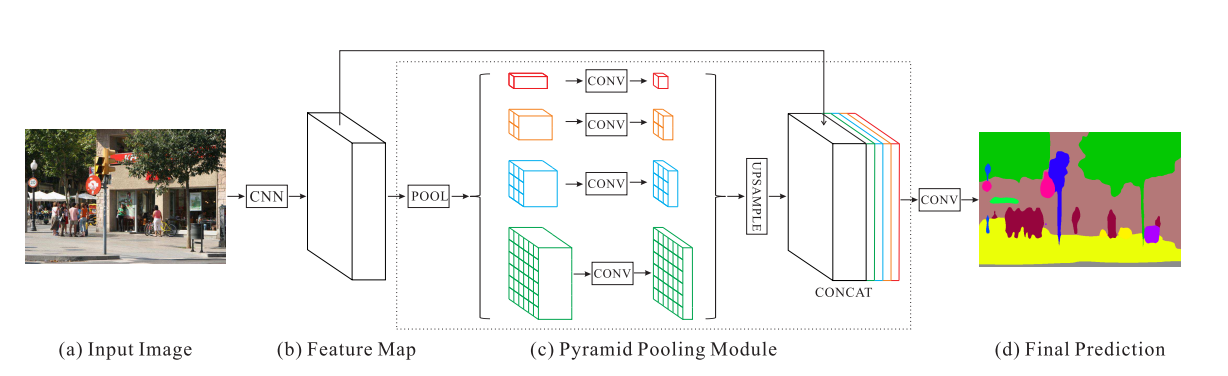

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PSPNet(nn.Module):
	def __init__(self, n_classes):
		super().__init__()

		block_config = [3, 4, 6, 3]  # resnet50
		img_size = 224
		img_size_8 = 56  # img_size to 1/8

		# 4 module for subnetwork
		self.feature_conv = FeatureMap_convolution()

		self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
			6, 3, 2, 1], height=img_size_8, width=img_size_8)

		self.decode_feature = DecodePSPFeature(
			height=img_size, width=img_size, n_classes=n_classes)

		self.aux = AuxiliaryPSPlayers(
			in_channels=2048, height=img_size, width=img_size, n_classes=n_classes)

	def forward(self, x):
		x = self.feature_conv(x)

		output_aux = self.aux(x)  #  a part of Feature module into Aux module


		x = self.pyramid_pooling(x)
		output = self.decode_feature(x)

		return (output, output_aux)

class conv2DBatchNormRelu(nn.Module):
	def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
		super().__init__()
		self.conv = nn.Conv2d(in_channels, out_channels,
							  kernel_size, stride, padding, dilation, bias=bias)
		self.batchnorm = nn.BatchNorm2d(out_channels)
		self.relu = nn.ReLU(inplace=True)
		# inplace=True, decrease memory consumption by not preserving input

	def forward(self, x):
		x = self.conv(x)
		x = self.batchnorm(x)
		outputs = self.relu(x)

		return outputs

class FeatureMap_convolution(nn.Module):
        def __init__(self):
                super().__init__()

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
                self.cbnr_1 = conv2DBatchNormRelu(
                  in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
                self.cbnr_2 = conv2DBatchNormRelu(
                  in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
                self.cbnr_3 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 128, 256, 3, 1, 1, 1, False
                self.cbnr_4 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 256, 512, 3, 1, 1, 1, False
                self.cbnr_5 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 512, 1024, 3, 1, 1, 1, False
                self.cbnr_6 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 1024, 2048, 3, 1, 1, 1, False
                self.cbnr_7 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)



        def forward(self, x):
                x = self.cbnr_1(x)
                x = self.cbnr_2(x)
                x = self.cbnr_3(x)
                x = self.cbnr_4(x)
                x = self.cbnr_5(x)
                x = self.cbnr_6(x)
                x = self.cbnr_7(x)
                outputs = self.maxpool(x)
                return outputs



class conv2DBatchNorm(nn.Module):
	def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
		super().__init__()
		self.conv = nn.Conv2d(in_channels, out_channels,
							  kernel_size, stride, padding, dilation, bias=bias)
		self.batchnorm = nn.BatchNorm2d(out_channels)

	def forward(self, x):
		x = self.conv(x)
		outputs = self.batchnorm(x)

		return outputs



class PyramidPooling(nn.Module):
	def __init__(self, in_channels, pool_sizes, height, width):
		super().__init__()

		self.height = height
		self.width = width

		out_channels = int(in_channels / len(pool_sizes))

		# pool_sizes: [6, 3, 2, 1]
		self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
		self.cbr_1 = conv2DBatchNormRelu(
			in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

		self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
		self.cbr_2 = conv2DBatchNormRelu(
			in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

		self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
		self.cbr_3 = conv2DBatchNormRelu(
			in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

		self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
		self.cbr_4 = conv2DBatchNormRelu(
			in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

	def forward(self, x):

		out1 = self.cbr_1(self.avpool_1(x))
		out1 = F.interpolate(out1, size=(
			self.height, self.width), mode="bilinear", align_corners=True)

		out2 = self.cbr_2(self.avpool_2(x))
		out2 = F.interpolate(out2, size=(
			self.height, self.width), mode="bilinear", align_corners=True)

		out3 = self.cbr_3(self.avpool_3(x))
		out3 = F.interpolate(out3, size=(
			self.height, self.width), mode="bilinear", align_corners=True)

		out4 = self.cbr_4(self.avpool_4(x))
		out4 = F.interpolate(out4, size=(
			self.height, self.width), mode="bilinear", align_corners=True)

		if (x.size(2) != out1.size(2) or out1.size(2) != out2.size(2)):
			print(x.size(), out1.size(), out2.size(), out3.size(), out4.size())

		output = torch.cat([x, out1, out2, out3, out4], dim=1)

		return output

class DecodePSPFeature(nn.Module):
	def __init__(self, height, width, n_classes):
		super().__init__()

		self.height = height
		self.width = width

		self.cbr = conv2DBatchNormRelu(
			in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
		self.dropout = nn.Dropout2d(p=0.1)
		self.classification = nn.Conv2d(
			in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

	def forward(self, x):
		x = self.cbr(x)
		x = self.dropout(x)
		x = self.classification(x)
		output = F.interpolate(
			x, size=(self.height, self.width), mode="bilinear", align_corners=True)
		return output

class AuxiliaryPSPlayers(nn.Module):
	def __init__(self, in_channels, height, width, n_classes):
		super().__init__()

		self.height = height
		self.width = width

		self.cbr = conv2DBatchNormRelu(
			in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
		self.dropout = nn.Dropout2d(p=0.1)
		self.classification = nn.Conv2d(
			in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

	def forward(self, x):
		x = self.cbr(x)
		x = self.dropout(x)
		x = self.classification(x)
		output = F.interpolate(
			x, size=(self.height, self.width), mode="bilinear", align_corners=True)
		return output